In [ ]:
## Plot maker! 
_______________________________________________

In [1]:
#############################
# Initilize 
#############################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize


# Set global plot params


fontsize = 6
figsize = (6,3)
dpi = 350

plt.rcParams.update({'font.size': fontsize, 'figure.figsize': figsize, 'figure.dpi': dpi})
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5




plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'





In [3]:
# Sherpa Initialization
from sherpa.data import Data1D #Sherpa data structure

from sherpa.fit import Fit # Model fitting
from sherpa.stats import Chi2 # Chi-2
from sherpa.models.basic import PowLaw1D # Model
from sherpa.optmethods import LevMar  # Optimization method
from sherpa.estmethods import Confidence # Error analysis
from sherpa.plot import RegionProjection # Contour plots

In [401]:
#########################
# Read in data
########################

#Specify working directory
#path = '/Users/bbonine/ou/research/corr_func/outputs/all/03_25_21_10xrand/nbins_25/'

path = '/Users/bbonine/ou/research/corr_func/outputs/all/04_05_21/nbins_25/'

# Read in output files
centers,corr,sig,fields = np.loadtxt(path+'out.txt', skiprows = 1, unpack = True)


#ratios = np.genfromtxt(path1+'ratio.txt',delimiter = ',')

print(corr)
# Select only positive values to use in the fit
pos_vals = np.where(corr > 0)[0]
print("Bins: " +str(len(centers)))
print("Values used: " +str(len(pos_vals)))




x = centers[pos_vals]
y = corr[pos_vals]
y_err = sig[pos_vals]





[1.386505   1.26702448 1.04315029 1.08703133 1.06246533 1.13283236
 1.02880506 1.07383924 1.02532978 1.00923816 1.03889028 1.04399858
 1.03544974 1.02288225 1.01571257 1.0315019  1.01046505 1.00498599
 1.00617292 1.00530781 1.0097007  0.99625384 0.97646186 0.79510785]
Bins: 24
Values used: 24


In [368]:
centers*(47.1262 / 20)

array([  20.48091823,   24.34161694,   28.93006595,   34.38344782,
         40.86480432,   48.56791096,   57.72307036,   68.6039977 ,
         81.53600407,   96.90572246,  115.17266699,  136.88297126,
        162.68571624,  193.35233612,  229.79968216,  273.11743411,
        324.60067879,  385.78862977,  458.51064581,  544.94092384,
        647.66350181,  769.74951453,  914.84901259, 1087.30008923])

In [402]:
####################
# Fit the data
#####################
#convert to log

logx = np.log10(x)
logy = np.log10(y)
logyerr =  (1/2.3)* (y_err / y)

#Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

# define our line fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p,x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args = (logx, logy, logyerr), full_output = 1)
pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**(pfinal[0])

indexErr = np.sqrt(covar[1][1])
ampErr = np.sqrt(covar[0][0]) * amp



[ 0.07328257 -0.03026839]
[[ 1.83473301e-04 -7.68559807e-05]
 [-7.68559807e-05  3.25916550e-05]]


(10, 1531.6014999999998)

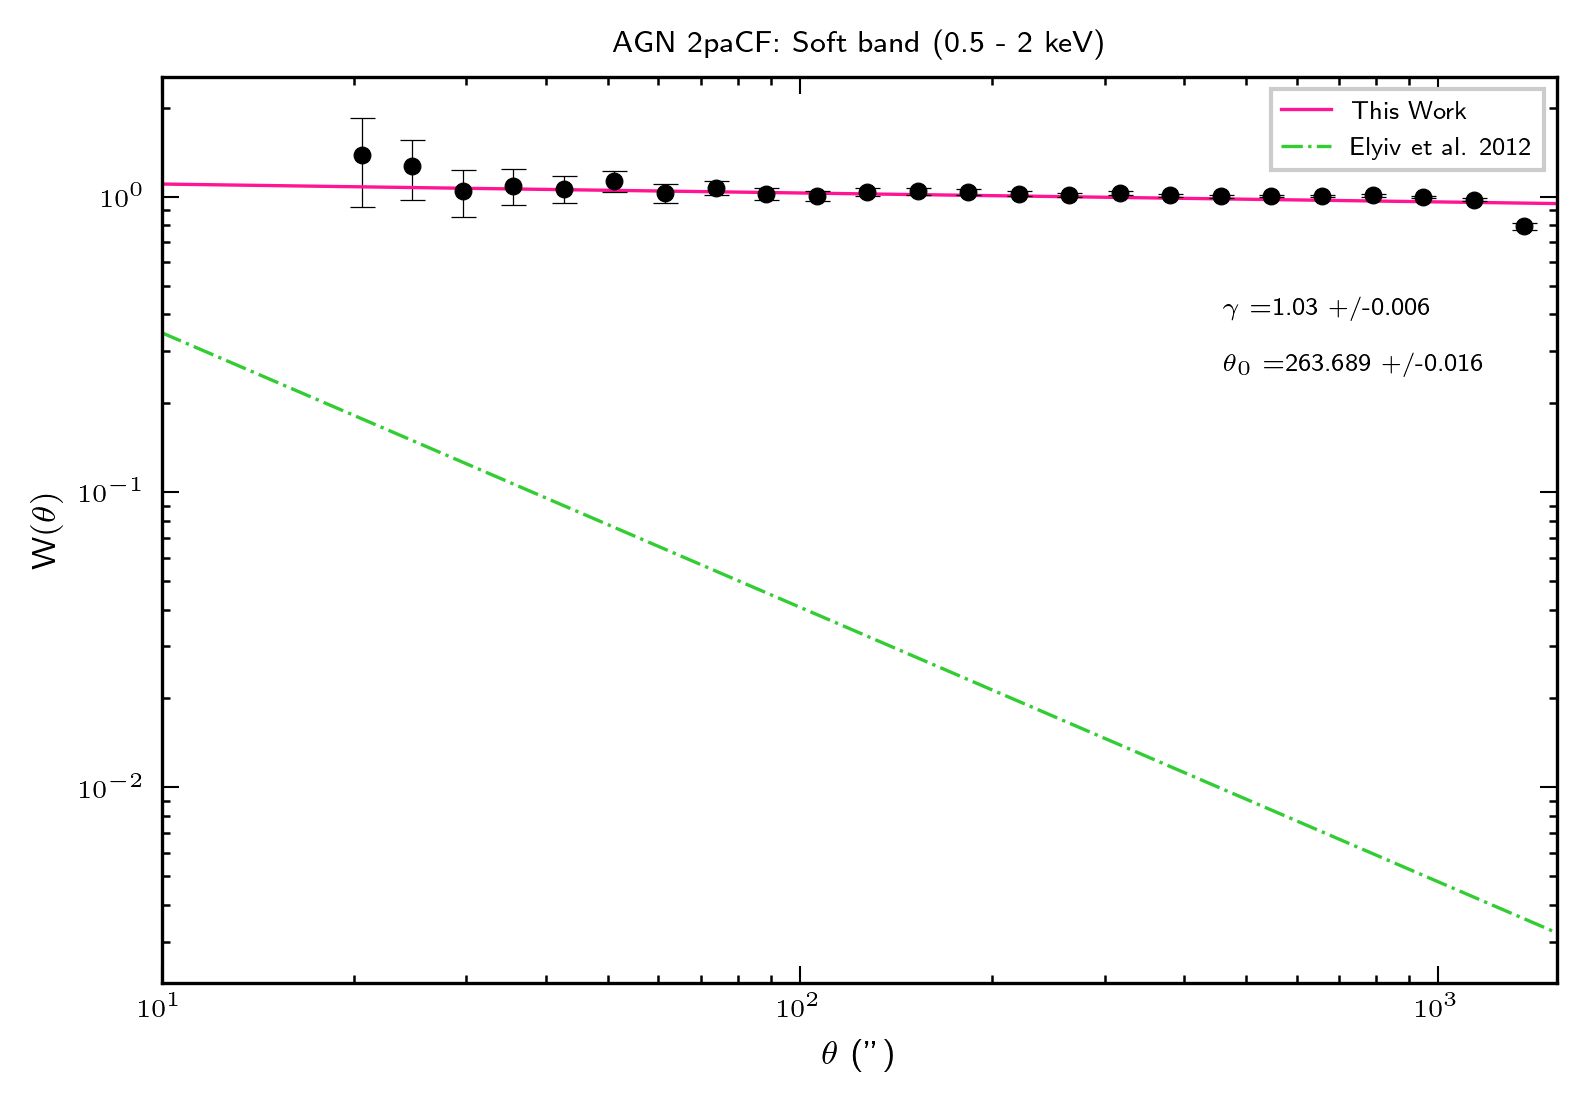

In [403]:
##################
# Plot 
##################
path_out = '/Users/bbonine/ou/general_exam/figs/'
pix_scale = 47.1262 / 20      # arcseconds / pixel for SWIFT XRT
x_fit = np.linspace(1,700,num = 1000)*pix_scale


'''
%%%%%%%%%%%%%%%%%%
Linear Scale Fit
%%%%%%%%%%%%%%%%%%
'''

plt.figure(figsize = [6,4], dpi = 300)

#Fit
plt.plot(x_fit,powerlaw(x_fit,amp,index), label = 'This Work', color = 'deeppink', linewidth = 0.8) # fit
plt.errorbar(centers*pix_scale,corr, yerr = sig, fmt = 'ko',elinewidth = 0.3, ms = 4, mew = 0.3, mfc = 'k', capsize = 3, linewidth = 0.8) # data
# Koutilidas Result
plt.plot(x_fit,(1/3.2)**(1-1.93)*(x_fit)**(1-1.93), label = 'Elyiv et al. 2012 ', color = 'limegreen', linewidth = 0.8, linestyle = '-.')
# Params
plt.title('AGN 2paCF: Soft band (0.5 - 2 keV)')
plt.xlabel(r'$\theta$ (")', fontsize = 8)
plt.ylabel(r'W$(\theta)$', fontsize = 8)
plt.legend(fontsize = 6, framealpha = 1, fancybox = False)

plt.xscale('log')
plt.yscale('log')
plt.text(460,0.25, r'$\theta_0 = $' + str(np.around(1/(amp**(1/index)),3)) + " +/-" + str(np.around(ampErr,3)), fontsize = 6)
plt.text(460,0.4, r'$\gamma = $' + str(np.around(1-index,3)) + " +/-" + str(np.around(indexErr,3)),fontsize = 6)

plt.xlim(10,650*pix_scale)
#plt.savefig(path_out+'corr_all.png')
#plt.close()

In [397]:
# Save to sherpa data structure
d = Data1D('data',x,y,staterror = y_err)
print(d)

name      = data
x         = Float64[24]
y         = Float64[24]
staterror = Float64[24]
syserror  = None


In [398]:
opt = LevMar()
ustat = Chi2()
pe = PowLaw1D('perr')
print(pe)


perr
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   perr.gamma   thawed            1          -10           10           
   perr.ref     frozen            1 -3.40282e+38  3.40282e+38           
   perr.ampl    thawed            1            0  3.40282e+38           


In [399]:
pe.ampl.min = 0
pe.ref = 0.6
print(pe)

perr
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   perr.gamma   thawed            1          -10           10           
   perr.ref     frozen          0.6 -3.40282e+38  3.40282e+38           
   perr.ampl    thawed            1            0  3.40282e+38           


In [400]:
plfit = Fit(d, pe, stat=ustat, method=opt)
plres = plfit.fit()
print(plres.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 576.907
Final fit statistic   = 186.677 at function evaluation 16
Data points           = 24
Degrees of freedom    = 22
Probability [Q-value] = 4.49904e-28
Reduced statistic     = 8.4853
Change in statistic   = 390.231
   perr.gamma     1.00541      +/- 0.0462865   
   perr.ampl      10.431       +/- 2.15671     


(10, 1649.4169999999997)

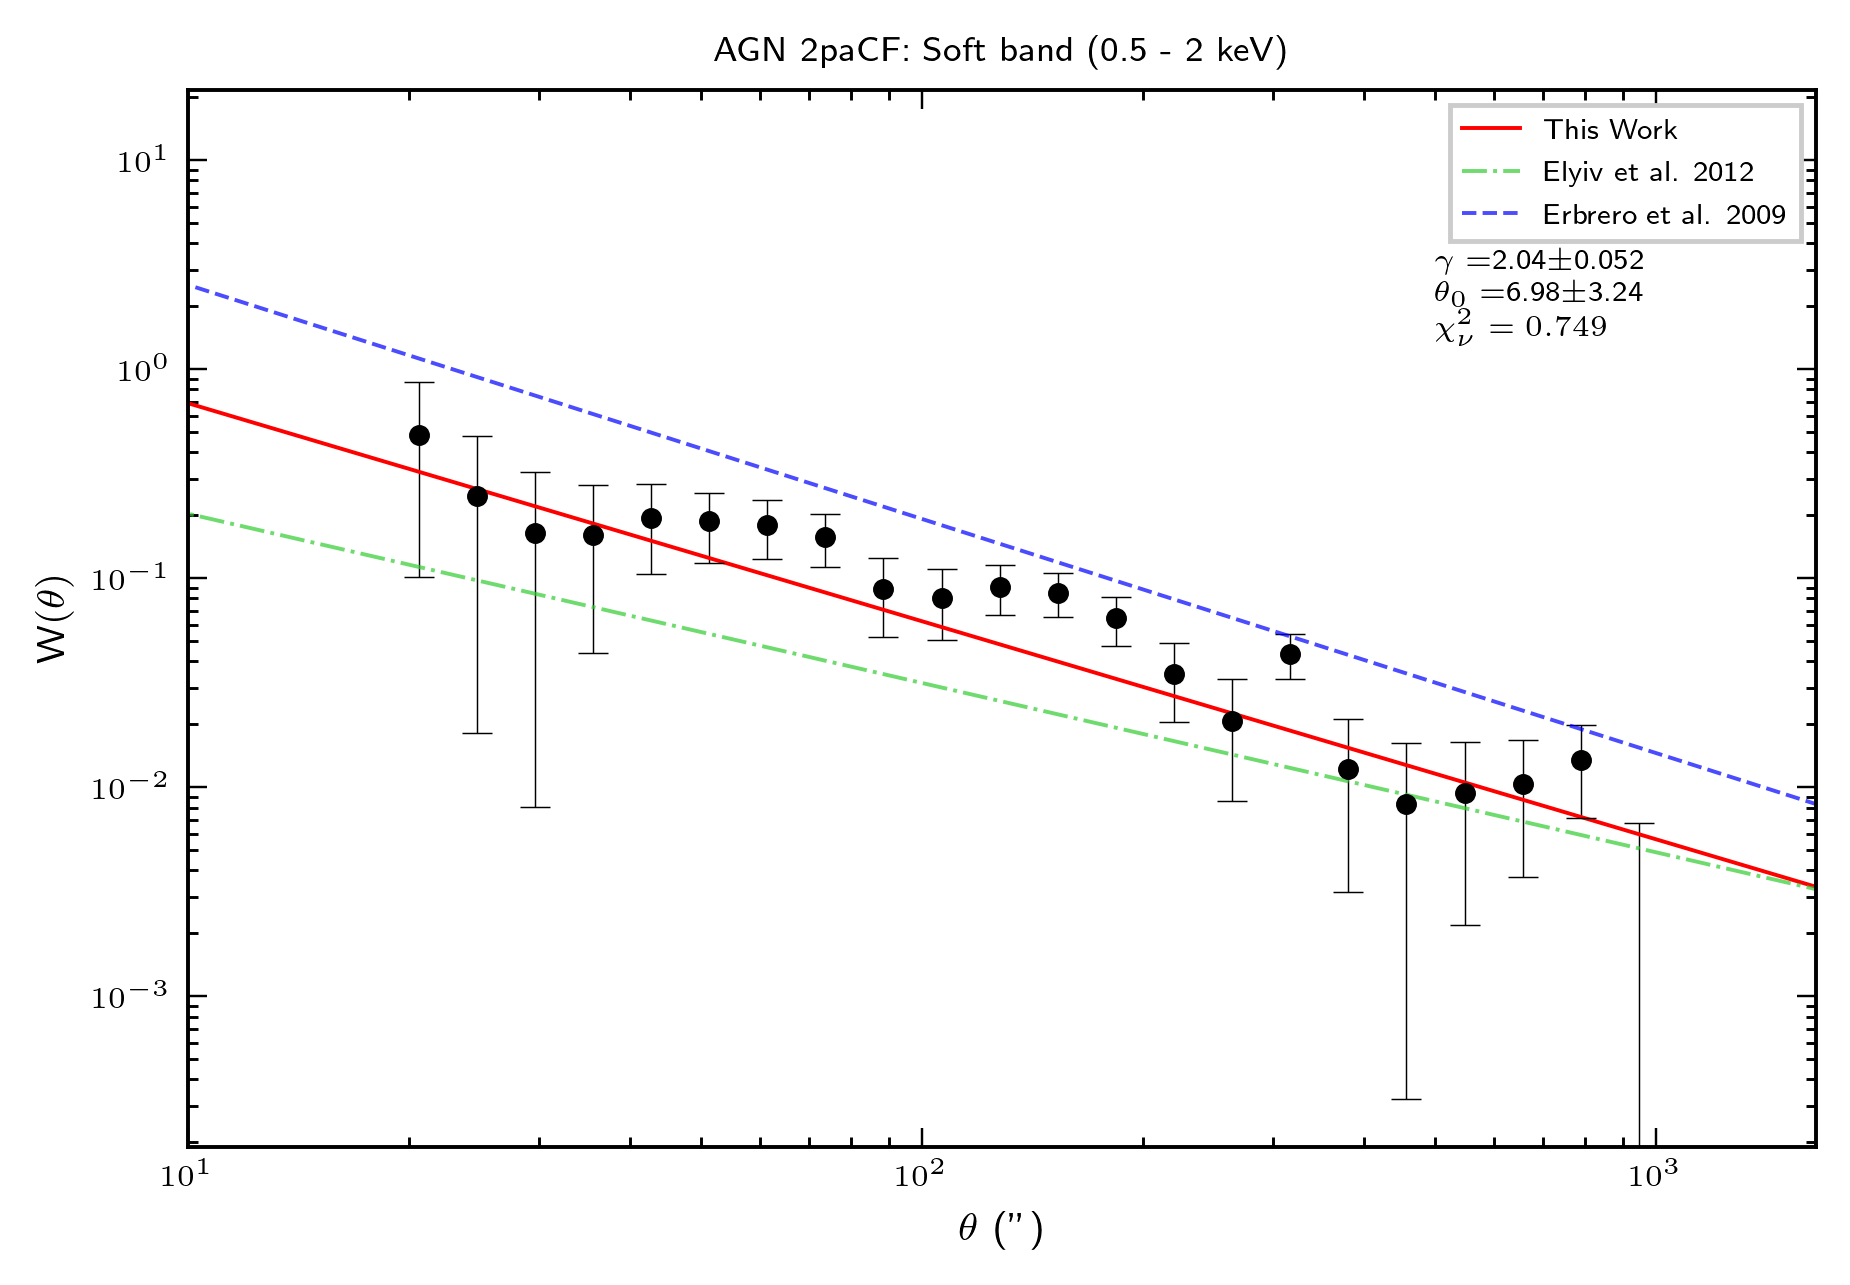

In [387]:
# Plot according to model
ampl_new = pe.pars[2].val
index_new = pe.pars[0].val

def plaw(A,x,beta):
    return A*(x**-beta)

##################
# Plot 
##################
pix_scale = 47.1262 / 20      # arcseconds / pixel for SWIFT XRT
x_fit = np.linspace(1,700,num = 1000)*pix_scale

plt.figure(figsize = [6,4],dpi = 350)
#Fit
plt.plot(x_fit,plaw(ampl_new,x_fit,index_new), label = 'This Work', color = 'red', linewidth = 0.8) # fit

plt.errorbar(centers*pix_scale,corr, yerr = sig, fmt = 'ko',elinewidth = 0.3, ms = 4, mew = 0.3, mfc = 'k', capsize = 3, linewidth = 0.8) # data

# Elyiv Result
plt.plot(x_fit,(1/1.4)**(1-1.81)*(x_fit)**(1-1.81), label = 'Elyiv et al. 2012 ', color = 'limegreen', linewidth = 0.8, linestyle = '-.', alpha = 0.7)

# Ebrero Result
plt.plot(x_fit,(1/22.9)**(-1.12)*(x_fit)**(-1.12), label = 'Erbrero et al. 2009 ', color = 'blue', linewidth = 0.8, linestyle = '--', alpha = 0.7)
# Params
plt.title('AGN 2paCF: All (0.5 - 8 keV)')
plt.xlabel(r'$\theta$ (")', fontsize = 8)
plt.ylabel(r'W$(\theta)$', fontsize = 8)
plt.legend(fontsize = 6, fancybox = False, framealpha = 1)

plt.xscale('log')
plt.yscale('log')

plt.text(500,3, r'$\gamma = $' + str(np.around(1+index_new,2)) + r'$\pm$' + str(0.052) ,fontsize = 6)
plt.text(500,2, r'$\theta_0 = $' + str(np.around(1/(ampl_new**(1/-index_new)),2))+r'$\pm$'  + str(np.around((1/3.41**(1/-index_new)),2)), fontsize = 6)
plt.text(500,1.3, r'$\chi_\nu^2 = 0.749$', fontsize = 6)

plt.xlim(10,700*pix_scale)
#plt.savefig('/Users/bbonine/ou/general_exam/figs/corr_all.png')



(0, 1000)

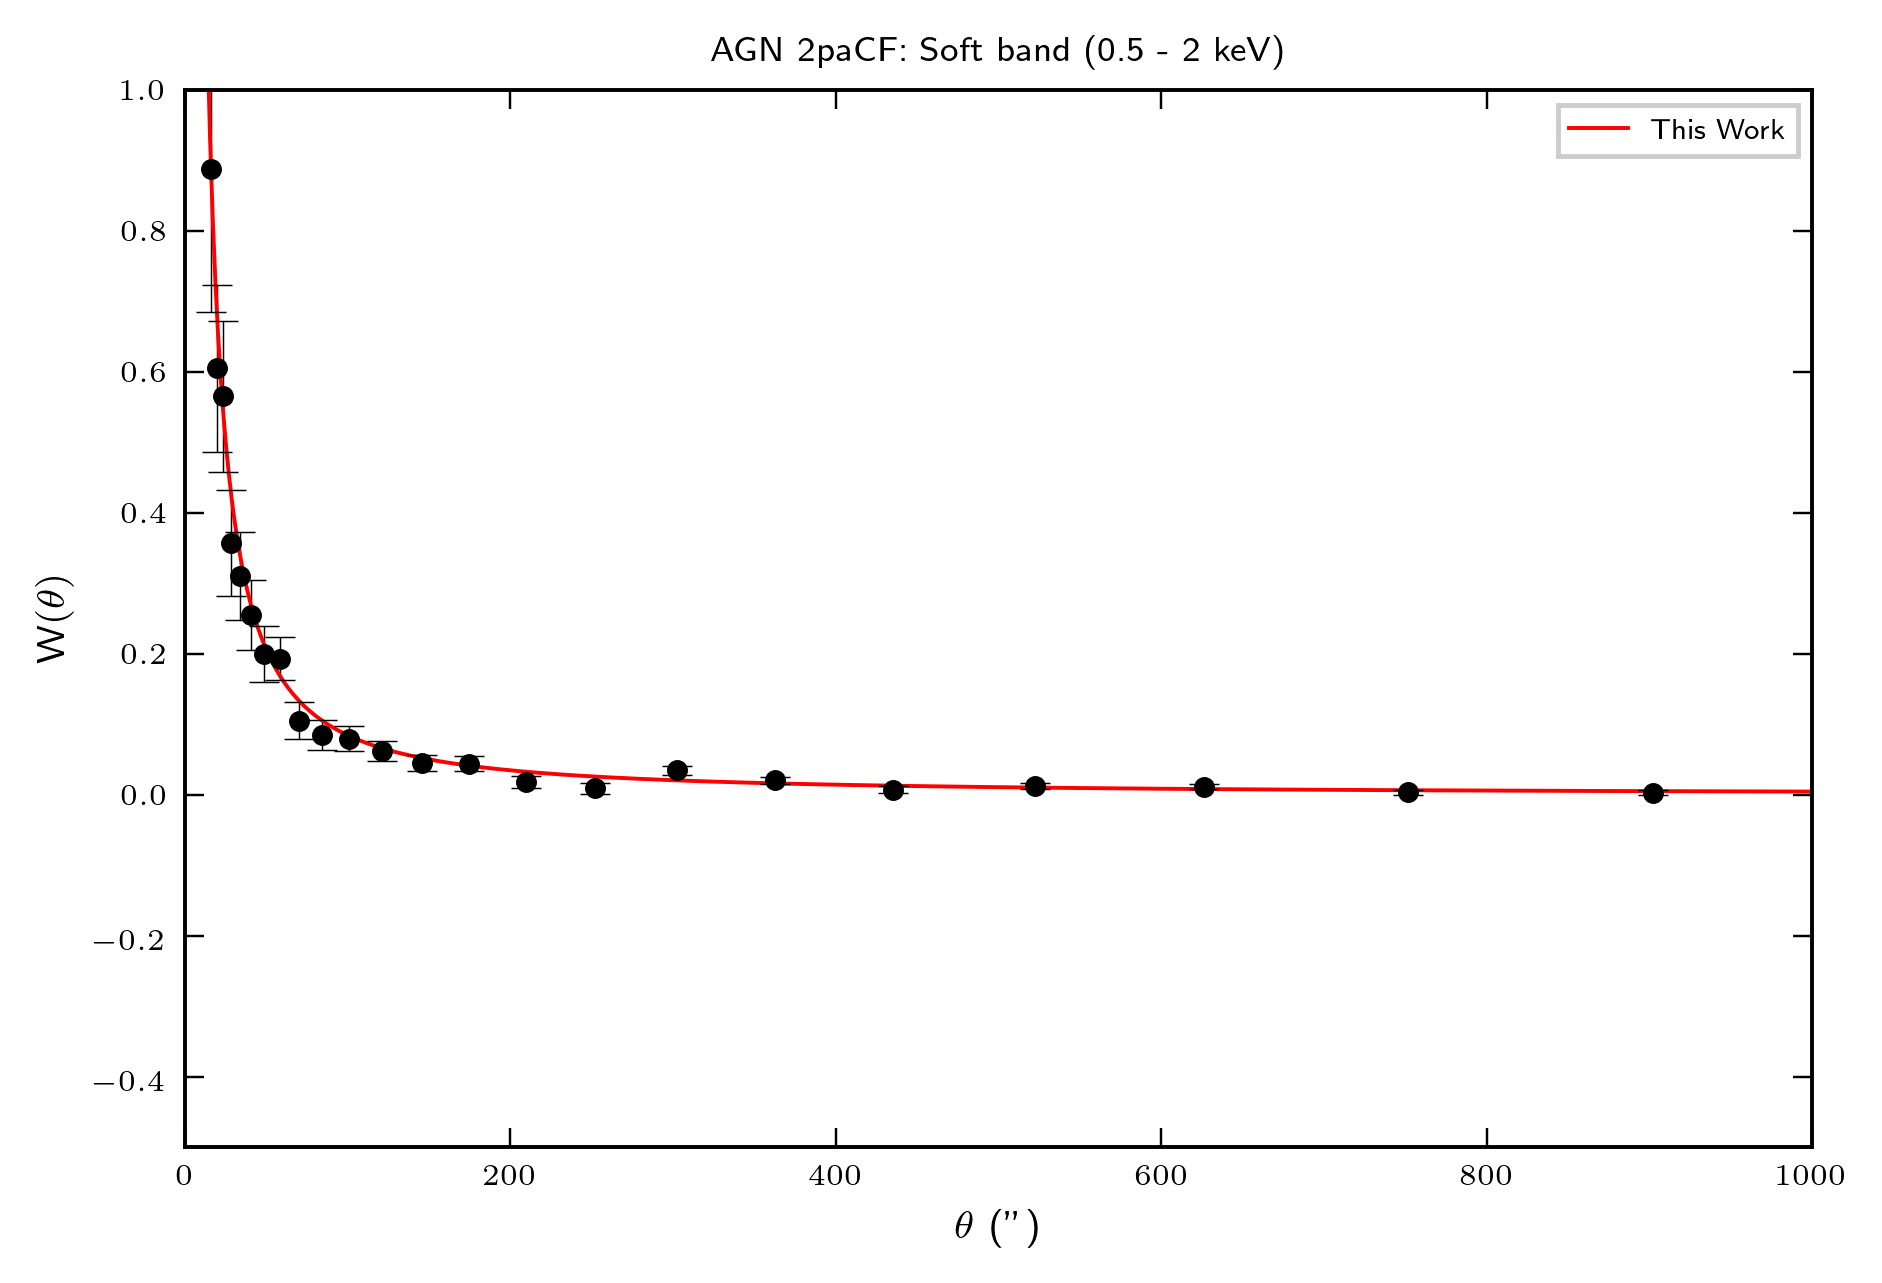

In [39]:
# In lin space
ampl_new = pe.pars[2].val
index_new = pe.pars[0].val

def plaw(A,x,beta):
    return A*(x**-beta)

##################
# Plot 
##################
pix_scale = 47.1262 / 20      # arcseconds / pixel for SWIFT XRT
x_fit = np.linspace(1,700,num = 1000)*pix_scale

plt.figure(figsize = [6,4],dpi = 350)
#Fit
plt.plot(x_fit,plaw(ampl_new,x_fit,index_new), label = 'This Work', color = 'red', linewidth = 0.8) # fit

plt.errorbar(centers*pix_scale,corr, yerr = sig, fmt = 'ko',elinewidth = 0.3, ms = 4, mew = 0.3, mfc = 'k', capsize = 3, linewidth = 0.8) # data

# Elyiv Result
#plt.plot(x_fit,(1/1.4)**(1-1.81)*(x_fit)**(1-1.81), label = 'Elyiv et al. 2012 ', color = 'limegreen', linewidth = 0.8, linestyle = '-.', alpha = 0.7)

# Ebrero Result
#plt.plot(x_fit,(1/22.9)**(-1.12)*(x_fit)**(-1.12), label = 'Erbrero et al. 2009 ', color = 'blue', linewidth = 0.8, linestyle = '--', alpha = 0.7)
# Params
plt.title('AGN 2paCF: Soft band (0.5 - 2 keV)')
plt.xlabel(r'$\theta$ (")', fontsize = 8)
plt.ylabel(r'W$(\theta)$', fontsize = 8)
plt.legend(fontsize = 6, fancybox = False, framealpha = 1)

plt.ylim(-0.5,1)
plt.xlim(0,1000)

#plt.text(450,3, r'$\gamma = $' + str(np.around(1+index_new,2)) + r'$\pm$' + str(0.052) ,fontsize = 6)
#plt.text(450,2, r'$\theta_0 = $' + str(np.around(1/(ampl_new**(1/-index_new)),2))+r'$\pm$'  + str(np.around((1/1.22**(1/-index_new)),2)), fontsize = 6)
#plt.text(450,1.4, r'$\chi_\nu^2 = 1.59$', fontsize = 6)


In [26]:
index_new, ampl_new
print(1/(ampl_new**(1/index_new)))

6.400456665959288


In [388]:
# Try fixing gamma
opt = LevMar()
ustat = Chi2()
pe = PowLaw1D('perr')
print(pe)



perr
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   perr.gamma   thawed            1          -10           10           
   perr.ref     frozen            1 -3.40282e+38  3.40282e+38           
   perr.ampl    thawed            1            0  3.40282e+38           


In [389]:
pe.gamma = 0.8
pe.ref = 0.4
pe.gamma.frozen = True
print(pe.gamma)

val         = 0.8
min         = -10.0
max         = 10.0
units       = 
frozen      = True
link        = None
default_val = 0.8
default_min = -10.0
default_max = 10.0


In [390]:
plfit = Fit(d, pe, stat=ustat, method=opt)
plres = plfit.fit()
print(plres.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 76.3129
Final fit statistic   = 21.1354 at function evaluation 4
Data points           = 21
Degrees of freedom    = 20
Probability [Q-value] = 0.389199
Reduced statistic     = 1.05677
Change in statistic   = 55.1774
   perr.ampl      3.21776      +/- 0.298562    


(10, 1531.6014999999998)

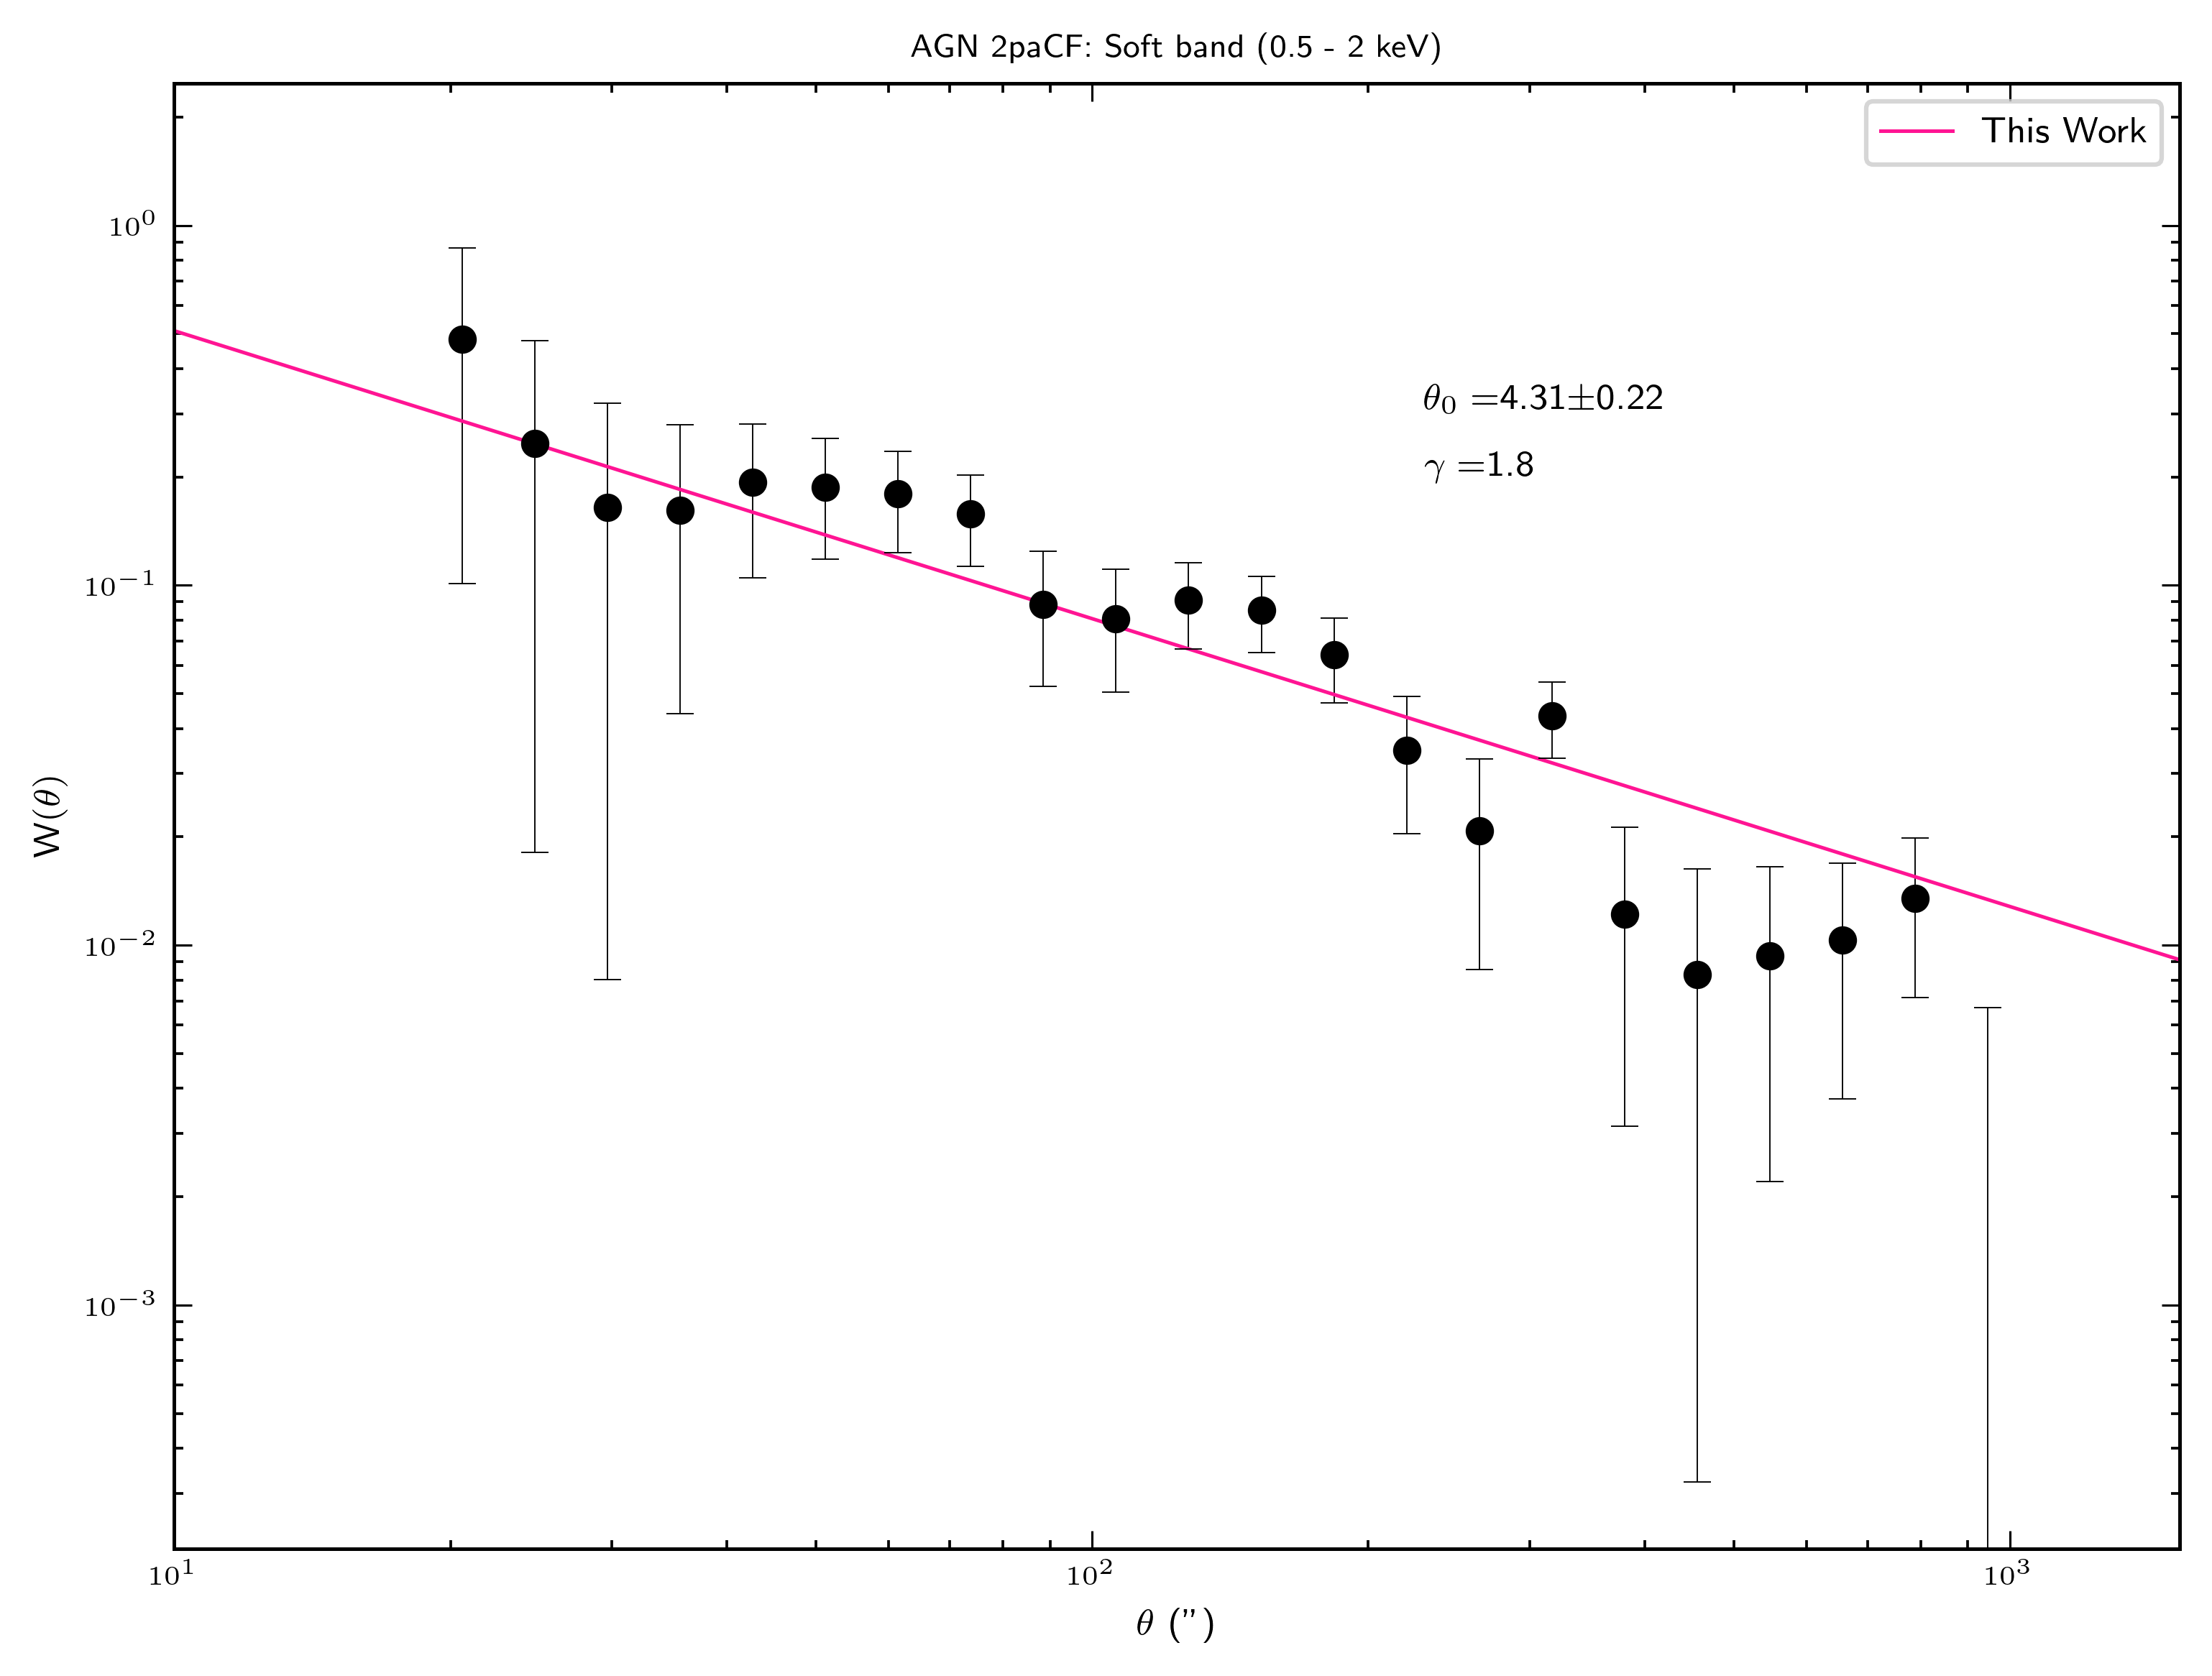

In [392]:
# Plot according to model
ampl_new = pe.pars[2].val
index_new = -pe.pars[0].val

##################
# Plot 
##################
pix_scale = 47.1262 / 20      # arcseconds / pixel for SWIFT XRT
x_fit = np.linspace(1,700,num = 1000)*pix_scale

plt.figure(figsize = [8,6], dpi = 450)

#Fit
plt.plot(x_fit,powerlaw(x_fit,ampl_new,index_new), label = 'This Work', color = 'deeppink', linewidth = 0.8) # fit
plt.errorbar(centers*pix_scale,corr, yerr = sig, fmt = 'ko',elinewidth = 0.3, ms = 6, mew = 0.3, mfc = 'k', capsize = 3, linewidth = 0.8) # data
# Koutilidas Result
#plt.plot(x_fit,(1/1.3)**(1-1.94)*(x_fit)**(1-1.94), label = 'Elyiv et al. 2012 ', color = 'limegreen', linewidth = 0.8, linestyle = '-.')
# Params
plt.title('AGN 2paCF: Soft band (0.5 - 2 keV)')
plt.xlabel(r'$\theta$ (")', fontsize = 8)
plt.ylabel(r'W$(\theta)$', fontsize = 8)
plt.legend(fontsize = 8)

plt.xscale('log')
plt.yscale('log')
plt.text(230,0.3, r'$\theta_0 = $' + str(np.around((1/(ampl_new**(1/index_new))),3)) + r'$\pm$' + str(np.around((1/(0.298**(1/index_new))),2)), fontsize = 8)
plt.text(230,0.2, r'$\gamma = $' + str(np.around(1-index_new,2)) ,fontsize = 8)

plt.xlim(10,650*pix_scale)

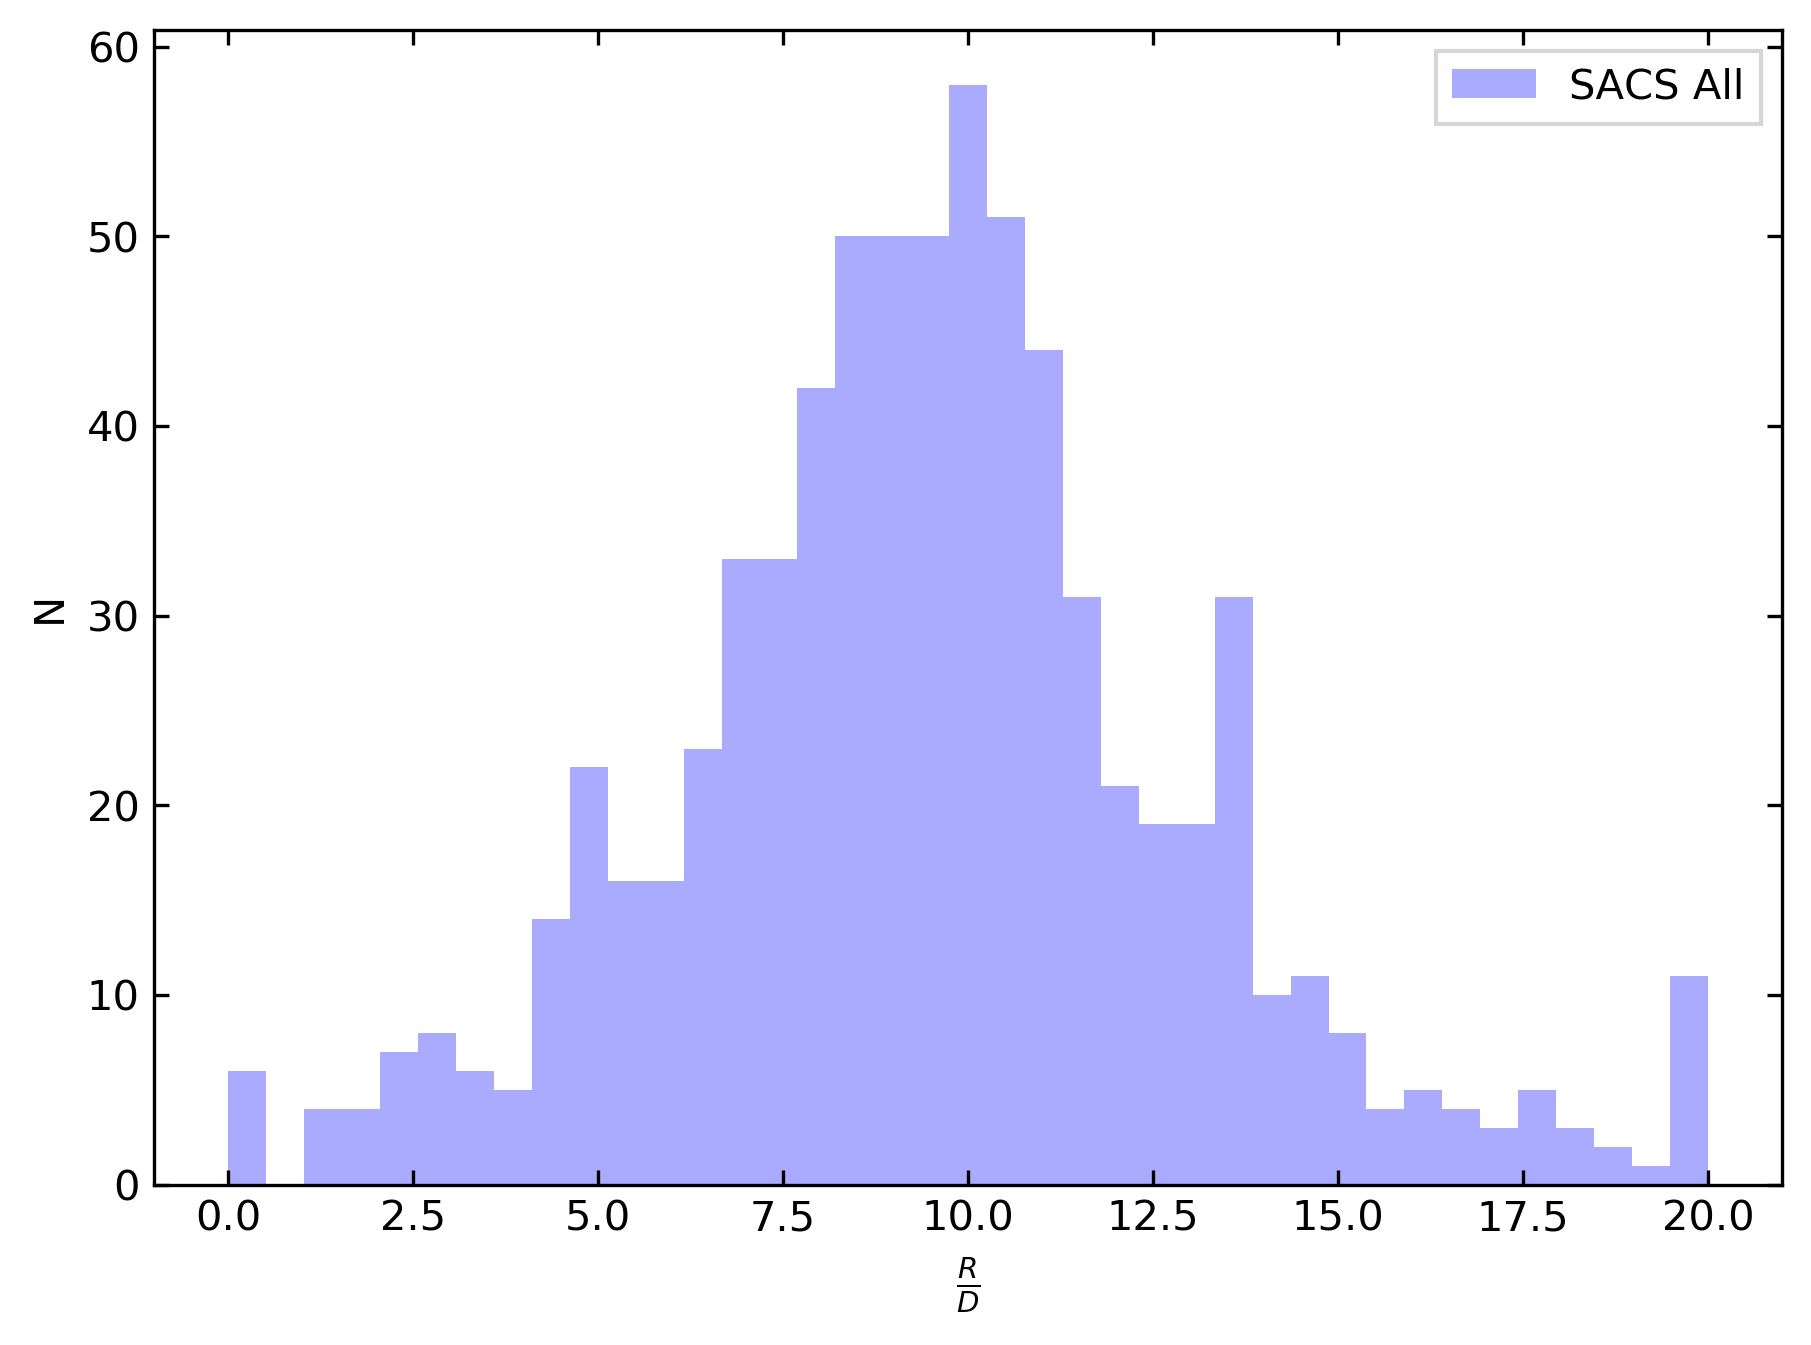

In [72]:
# Plot histogram
# Histograms
data,rand = np.loadtxt(path+'counts.txt',unpack=True,skiprows=1, usecols=(1,2))

ratio = rand/data
bins_hist = np.linspace(0,20,40)

plt.figure(figsize = [7,5], dpi = 300)
plt.hist(ratio,bins = bins_hist, color = '#AAAAFF', label = "SACS All")

plt.xlabel(r'$\frac{R}{D}$')
plt.ylabel('N')
plt.legend(fancybox = False)

### Null Result: 

In [207]:
#########################
# Read in data
########################

#Specify working directory
path = '/Users/bbonine/ou/research/corr_func/outputs/all/04_02_21_5xrand/nbins_25/'


# Read in output files
centers,corr,sig,fields = np.loadtxt(path+'out.txt', skiprows = 1, unpack = True)


#ratios = np.genfromtxt(path1+'ratio.txt',delimiter = ',')

# Select only positive values to use in the fit
pos_vals = np.where(corr > 0)[0]
print("Bins: " +str(len(centers)))
print("Values used: " +str(len(pos_vals)))




x = centers[pos_vals]
y = corr[pos_vals]
y_err = sig[pos_vals]

#x = centers
#y = corr
#y_err = sig

Bins: 25
Values used: 16


In [213]:
# Save to sherpa data structure
d = Data1D('data',x,y,staterror = y_err)
opt = LevMar()
ustat = Chi2()
pe = PowLaw1D('perr')
#pe.ref = 0.4
pe.ampl = 0
pe.ampl.frozen = True 


# Force amplitude to be zero for null model:





In [209]:
corr, centers*pix_scale,np.mean(corr[:-2])

(array([ 5.48394237e-03,  1.03592172e-03,  8.81474339e-03,  3.07445458e-03,
        -5.17537770e-03,  3.27520202e-03,  3.75310690e-03, -1.82283147e-03,
         3.48613258e-03, -1.54231543e-03, -2.48356418e-03,  1.27978741e-03,
         8.07145673e-04,  2.80661907e-04,  1.37913488e-03,  2.37019905e-03,
         6.85213449e-03,  2.05654075e-03,  1.52034639e-03, -2.05562899e-03,
        -1.55442183e-05, -8.73837395e-04,  2.16624420e-03, -6.04735711e-03,
        -4.11621328e-03]),
 array([  28.27572,   84.82716,  141.3786 ,  197.93004,  254.48148,
         311.03292,  367.58436,  424.1358 ,  480.68724,  537.23868,
         593.79012,  650.34156,  706.893  ,  763.44444,  819.99588,
         876.54732,  933.09876,  989.6502 , 1046.20164, 1102.75308,
        1159.30452, 1215.85596, 1272.4074 , 1328.95884, 1385.51028]),
 0.0014637651710117335)

In [214]:
plfit = Fit(d, pe, stat=ustat, method=opt)
plres = plfit.fit()
print(plres.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 33.7489
Final fit statistic   = 33.7489 at function evaluation 2
Data points           = 16
Degrees of freedom    = 15
Probability [Q-value] = 0.00369274
Reduced statistic     = 2.24993
Change in statistic   = 0
   perr.gamma     1            +/- 0           


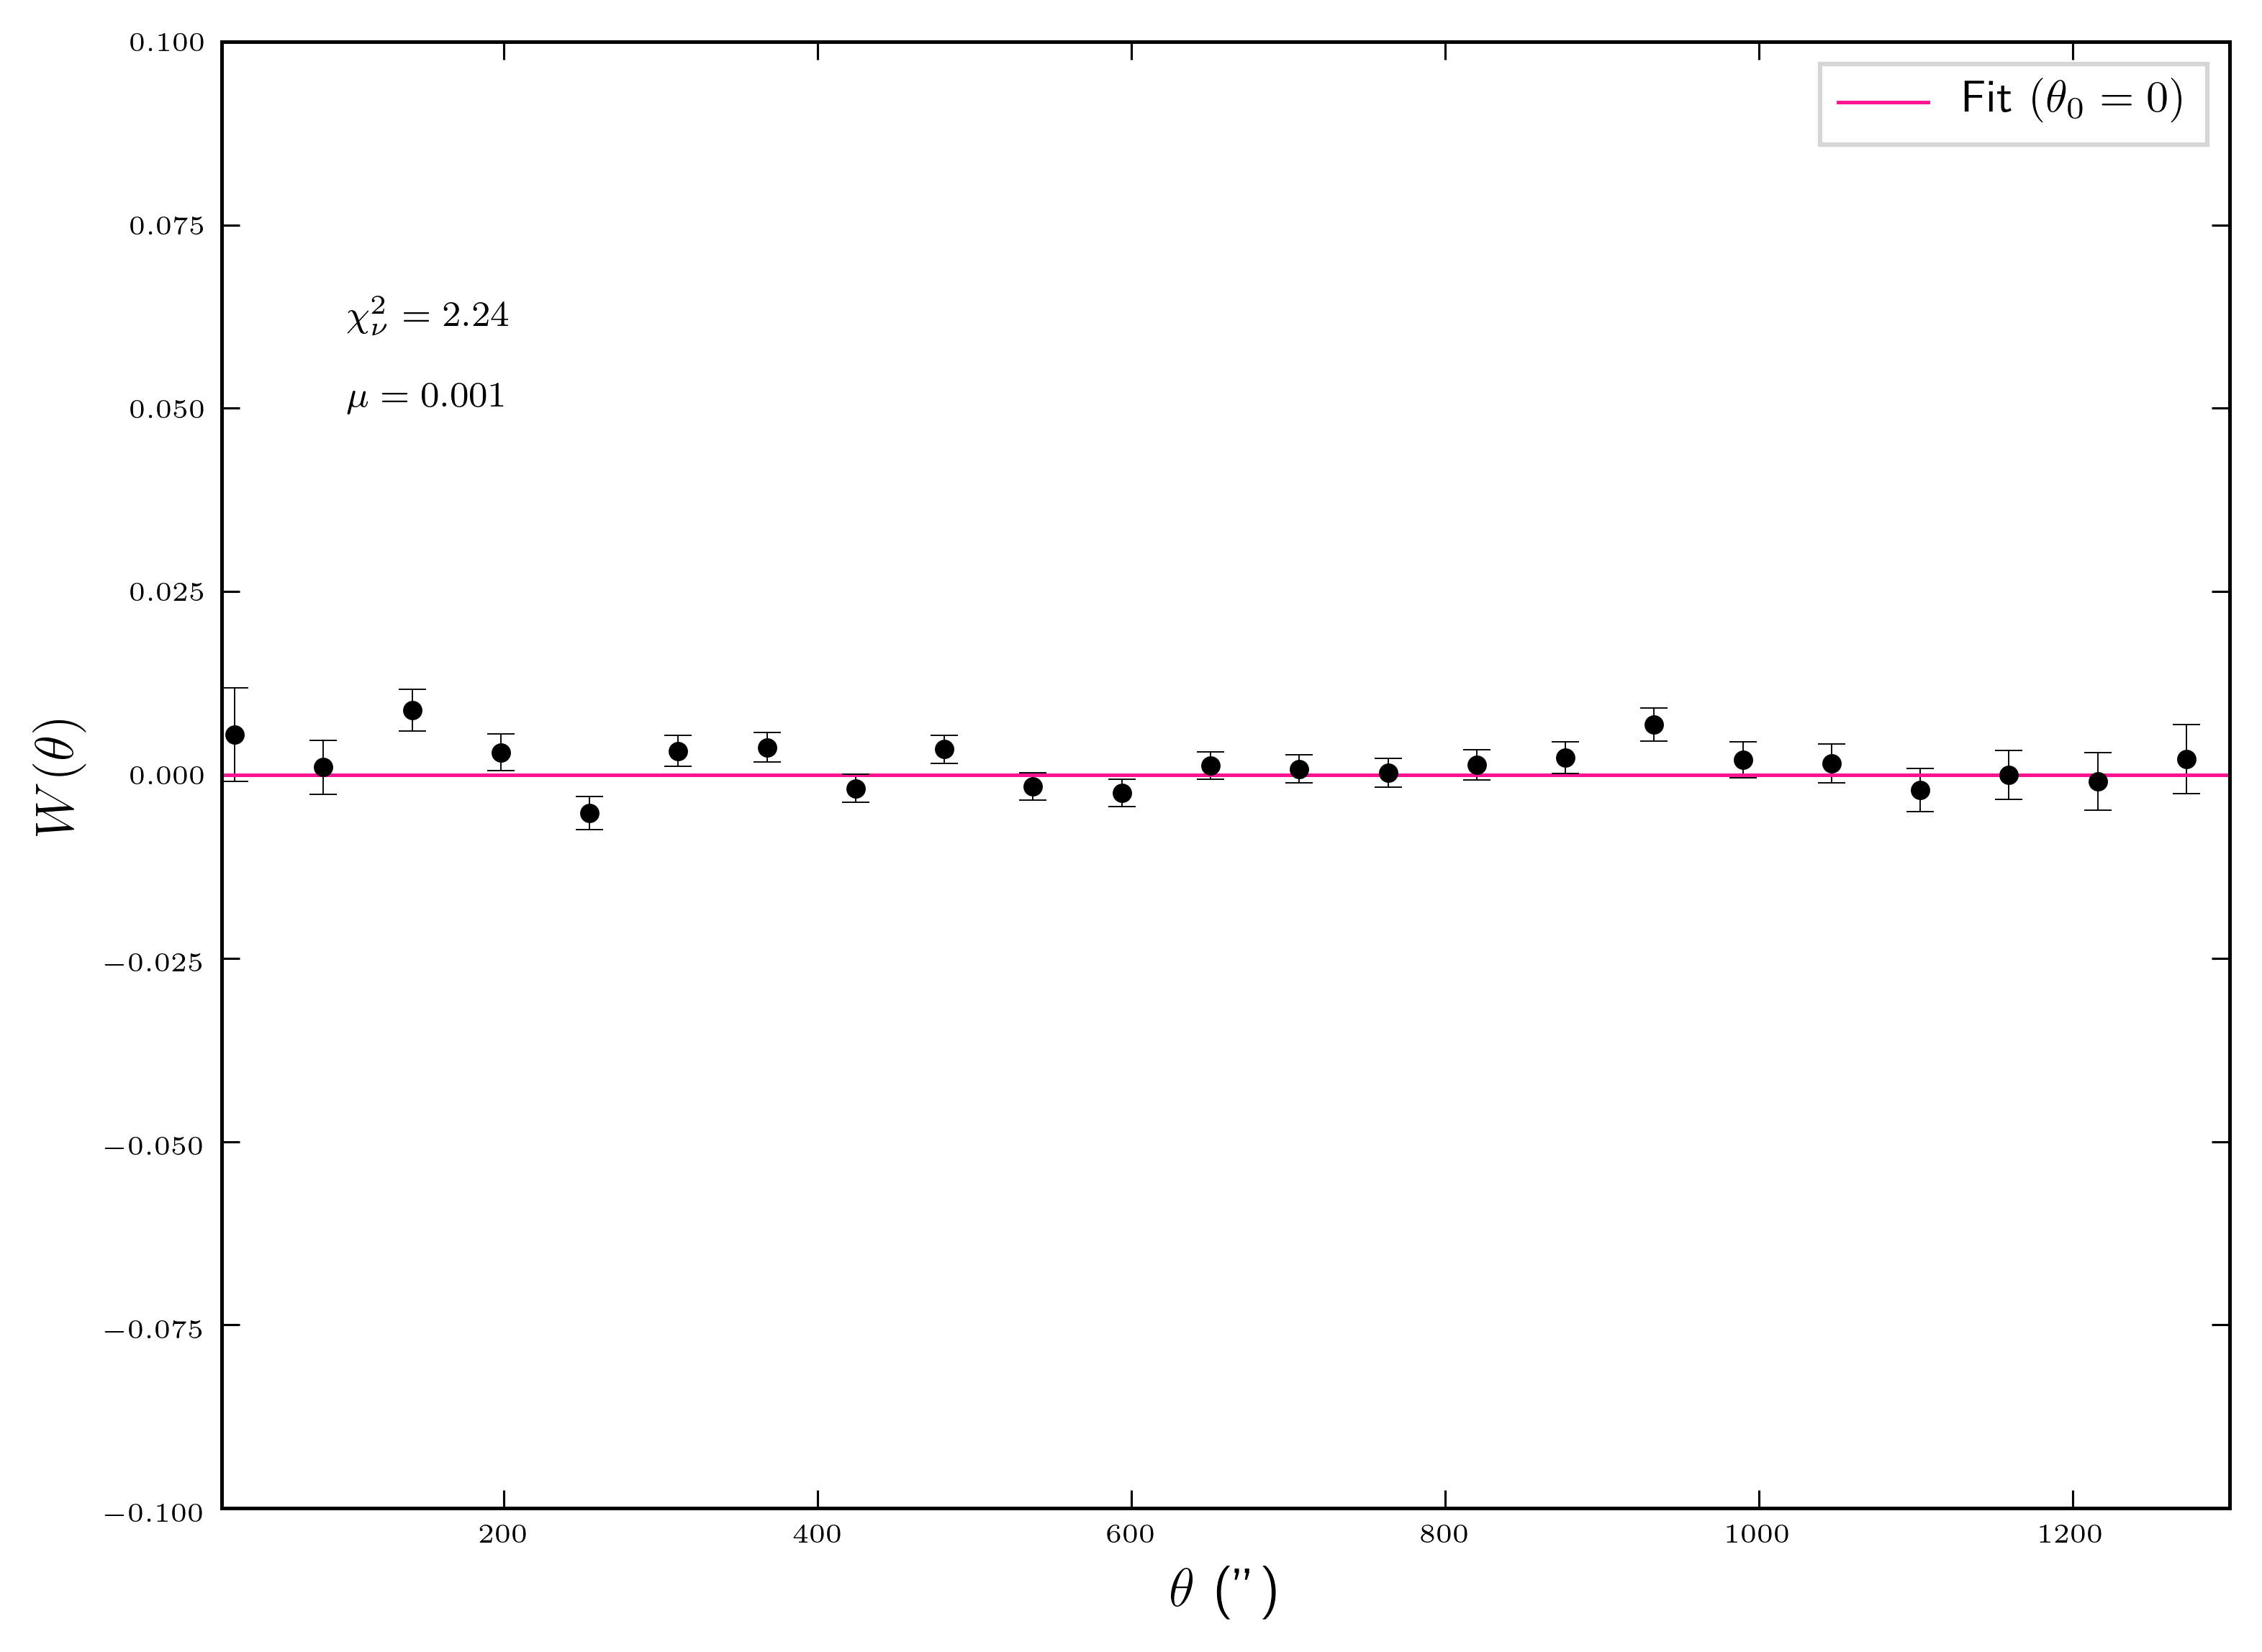

In [263]:
# Plot according to model
ampl_new = pe.pars[2].val
index_new = -pe.pars[0].val

##################
# Plot 
##################
pix_scale = 47.1262 / 20      # arcseconds / pixel for SWIFT XRT
x_fit = np.linspace(1,700,num = 1000)*pix_scale

plt.figure(figsize = [8,6], dpi = 450)

#Fit
plt.plot(x_fit,powerlaw(x_fit,ampl_new,index_new), label ='Fit ' r'$(\theta_0 = 0)$', color = 'deeppink', linewidth = 0.8) # fit
plt.errorbar(centers*pix_scale,corr, yerr = sig, fmt = 'ko',elinewidth = 0.3, ms = 4, mew = 0.3, mfc = 'k', capsize = 3, linewidth = 0.8) # data



plt.xlim(20,1300)
plt.ylim(-0.1,0.1)

plt.text(100,0.06,r'$\chi^2_\nu = 2.24$',fontsize = 8)
plt.text(100,0.05,r'$\mu  = 0.001$',fontsize = 8)

plt.xlabel(r'$\theta$ (")',fontsize = 12)
plt.ylabel(r'$W(\theta)$',fontsize = 12)
plt.legend(fancybox = False, fontsize = 10)
plt.savefig('/Users/bbonine/ou/general_exam/figs/corr_rand.png')





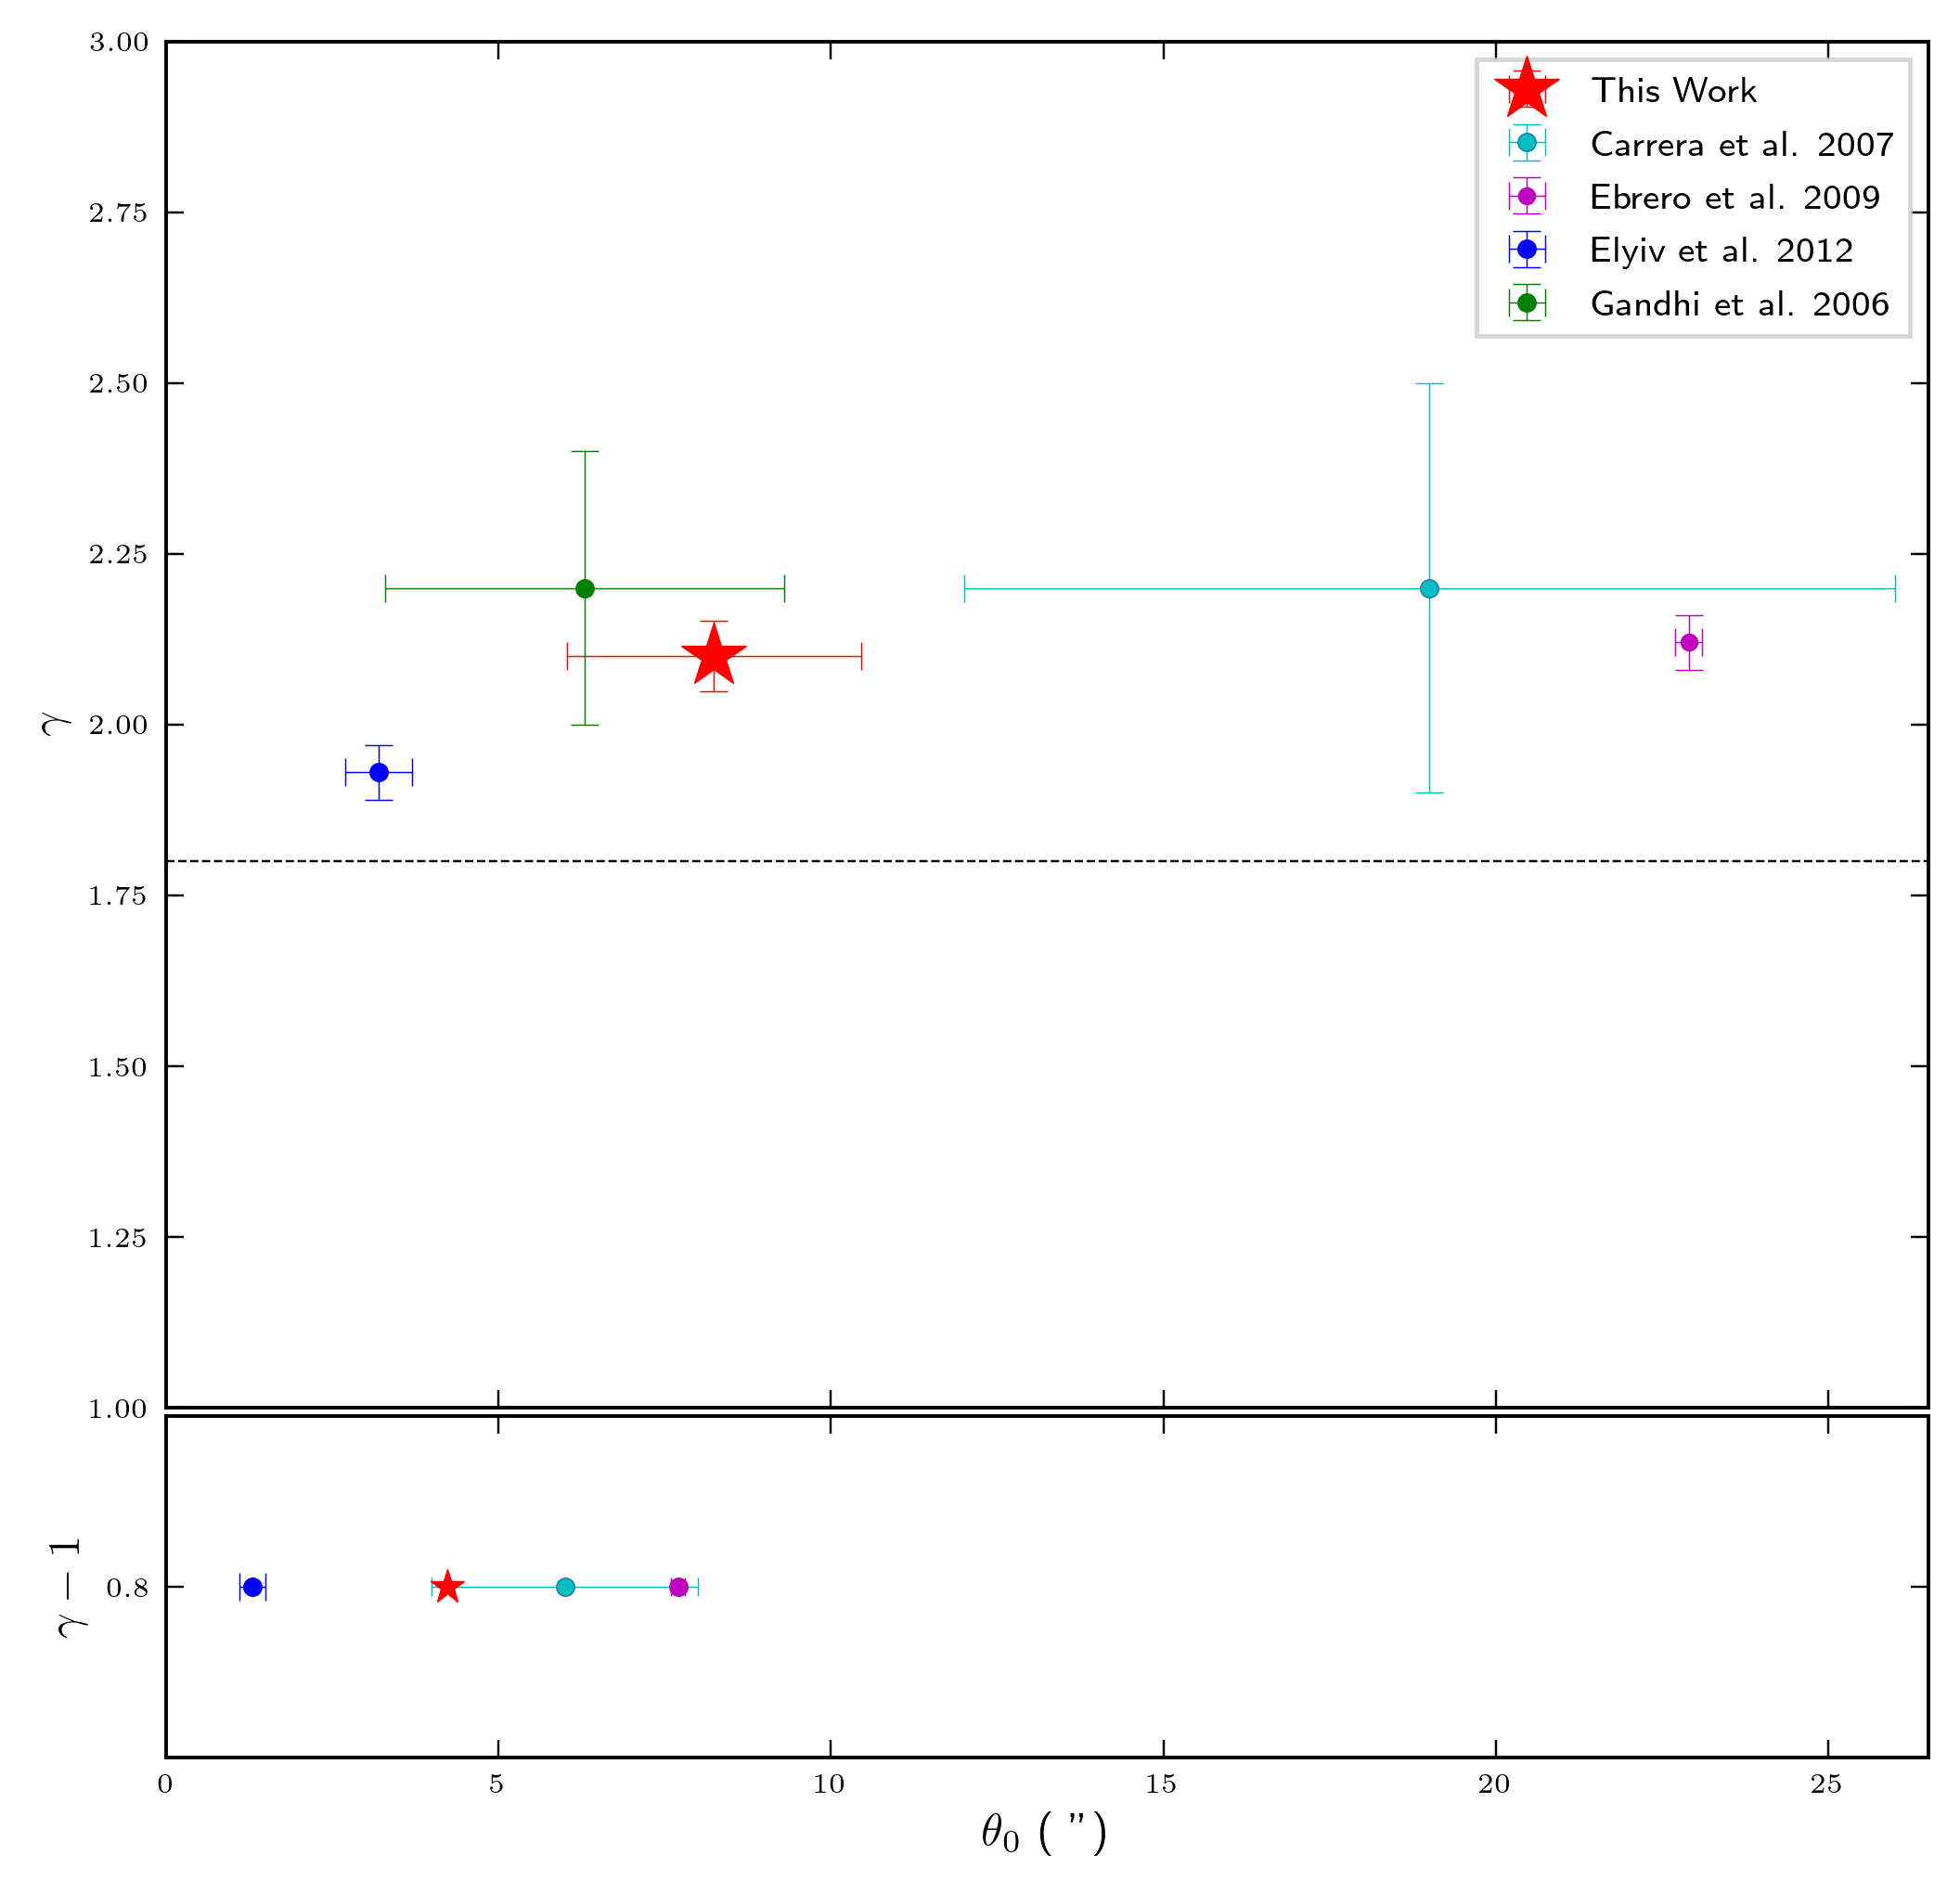

In [320]:
# New idea: plot results against other:
from matplotlib import gridspec 

fig,axs = plt.subplots(2, 1, sharex=True, figsize=(7, 7),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [4, 1],
                       'wspace': 0.4,
                       'hspace': 0.01})
fig.subplots_adjust(hspace=0)

# My results
axs[0].errorbar(8.24,2.1, xerr = 2.21, yerr = 0.052, label = 'This Work', fmt = 'r*',elinewidth = 0.3, ms = 15, mew = 0.3, mfc = 'r', capsize = 3)

# Carrera et al
axs[0].errorbar(19,2.2, xerr = 7, yerr = 0.3, label = 'Carrera et al. 2007', fmt = '.',ecolor = 'c',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'c', capsize = 3)

#Ebrero
axs[0].errorbar(22.9,2.12, xerr = 0.2, yerr = 0.04, label = 'Ebrero et al. 2009', fmt = 'm.',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'm', mec = 'none', capsize = 3)

#Elyiv
axs[0].errorbar(3.2,1.93, xerr = 0.5, yerr = 0.04, label = 'Elyiv et al. 2012', fmt = 'b.',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'b', capsize = 3)


# Ghandi 
axs[0].errorbar(6.3,2.2, xerr = 3, yerr = 0.2, label = 'Gandhi et al. 2006', fmt = 'g.',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'g', capsize = 3)



axs[0].set_ylim(1,3)

axs[0].set_xlim(0,26.5)
axs[0].set_ylabel(r'$\gamma$',fontsize = 10)

axs[0].hlines(1.8,0,26.5,linestyle = '--',linewidth = 0.5)

axs[0].legend(fontsize = 8,fancybox = False)

#plt.ylabel(r'$\gamma$',fontsize = 12)
#plt.xlabel(r'$\theta_0$ ( ")',fontsize = 12)



##############################################################
# Bottom plot
# My result
axs[1].errorbar(4.23,0.8, xerr = 0.04,  label = 'This Work', fmt = 'r*',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'r', capsize = 2)


# Carrera et al
axs[1].errorbar(6,0.8, xerr = 2, label = 'Carrera et al. 2007', fmt = '.',ecolor = 'c',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'c', capsize = 2)


#Ebrero
axs[1].errorbar(7.7,0.8, xerr = 0.1, label = 'Elyiv et al. 2012', fmt = 'm.',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'm', capsize = 2)

#Elyiv
axs[1].errorbar(1.3,0.8, xerr = 0.2, label = 'Elyiv et al. 2012', fmt = 'b.',elinewidth = 0.3, ms = 8, mew = 0.3, mfc = 'b', capsize = 3)


axs[1].set_ylim(0.75,0.85)

axs[1].set_xlabel(r'$\theta_0$ ( ")',fontsize = 10)
axs[1].set_ylabel(r'$\gamma - 1$',fontsize = 10)
axs[1].set_yticks(np.arange(.8,.81,1))




plt.savefig('/Users/bbonine/ou/general_exam/figs/results_compar.png')
  


#plt.legend(fancybox = 'False', fontsize = 10)


In [404]:
mean = [3.5601212470142958,3.867555568126389,1.7100444091063887,4.929079242832786,
2.3691575437249726,
1.7041944697798772,
1.1602765913550914,
1.689301663611218,
1.067571633401855,
0.6144545637934042,
0.5800016044533259,
0.41792307561685077,
0.4513969444563586,
0.4882145912710573,
0.28777114214583216,
0.20368092412429797,
0.16417037910841842,
0.2662660574043602,
0.06463208750901331,
0.09295130474656237,
0.06048789514680444,
0.05891746666602802,
0.03896734636746436]

In [412]:
# Save to sherpa data structure
d = Data1D('data',centers[:-1],mean)
print(d)

opt = LevMar()
ustat = Chi2()
pe = PowLaw1D('perr')

plfit = Fit(d, pe, stat=ustat, method=opt)
plres = plfit.fit()
print(plres.format())



name      = data
x         = Float64[23]
y         = Float64[23]
staterror = None
syserror  = None


StatErr: If you select chi2 as the statistic, all datasets must provide a staterror column

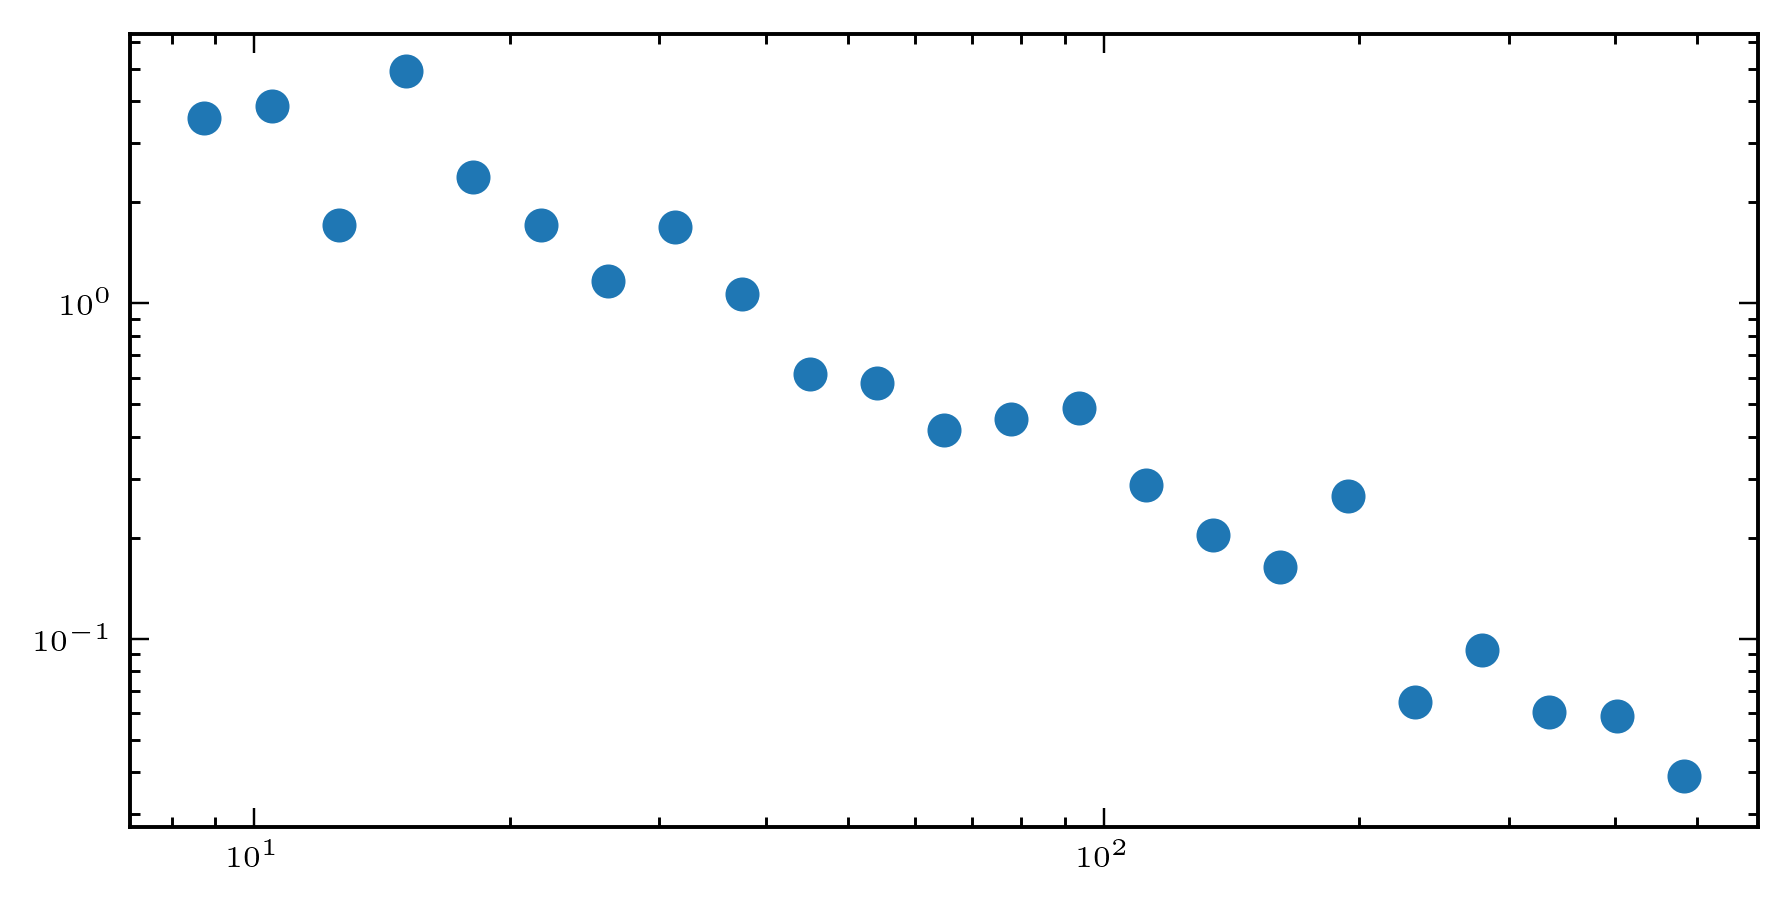

In [408]:
plt.scatter(centers[:-1],mean)
plt.xscale('log')
plt.yscale('log')